# Advanced Statistical Analysis and Predictive Modeling of NYC Taxi Trip Data: A Comprehensive Approach to Data Cleaning, Outlier Detection, Interpolation, and Hypothesis Testing

## Tean Memebers
1. Manthan Singh (115939891)
2. Bindu Bhargava Reddy Chintam(115824906)
3. Anish Philip (115675106)
4. Hein Zaw (115344093)

# 3.1.0 Import Required Packages, Libraries and Datasets

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

# import statsmodels.api as sm

In [3]:
# Load the datasets
df1 = pd.read_csv('../dataset/2023-04.csv')
df2 = pd.read_csv('../dataset/2023-05.csv')

# Merge the datasets
df = pd.concat([df1, df2], ignore_index=True)

# Display the first few rows of the combined dataset
df.head()

,lpep_pickup_datetime,passenger_count,trip_distance,trip_duration,fare_amount,tip_amount,congestion_surcharge
0,2023-04-01 00:01:46,1.0,2.62,596.0,13.5,3.00,0.00
1,2023-04-01 00:21:32,1.0,6.51,1904.0,33.8,7.81,2.75
2,2023-04-01 00:03:14,1.0,2.59,820.0,15.6,2.50,0.00
3,2023-04-01 00:22:17,1.0,0.70,317.0,6.5,2.65,0.00
4,2023-04-01 00:58:41,1.0,4.96,1359.0,25.4,5.58,0.00


# 3.1.1 Dataset Cleaning

In [4]:
# Delete rows where trip_distance is 0
df = df[df['trip_distance'] > 0]

# Replace negative values and zero values for specific columns with NaN
negative_cols = ['trip_distance', 'trip_duration', 'fare_amount', 'tip_amount', 'congestion_surcharge']
zero_check_cols = ['trip_duration', 'fare_amount']

for col in negative_cols:
    df.loc[df[col] < 0, col] = pd.NA

for col in zero_check_cols:
    df.loc[df[col] == 0, col] = pd.NA

# Convert 'lpep_pickup_datetime' to datetime
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

# Remove data which is not in given month of april and may
df = df[(df['lpep_pickup_datetime'].dt.month == 4) | (df['lpep_pickup_datetime'].dt.month == 5)]

# Saving the dataset into csv
df.to_csv('../dataset/cleaned_data.csv', index=False)

# 3.1.2 Outlier Detection

In [5]:
# Function to detect and mark outliers as NaN based on Tukey's rule
def mark_outliers(data, column, alpha=1.5):
    q25, q75 = data[column].quantile(0.25), data[column].quantile(0.75)
    iqr = q75 - q25
    lower_bound = q25 - (alpha * iqr)
    upper_bound = q75 + (alpha * iqr)

    # Count outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"Number of outliers in {column}: {len(outliers)}")

    # Mark outliers in the column as NaN
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = pd.NA

# Apply outlier detection to the specified columns
outlier_columns = ['passenger_count', 'trip_duration', 'fare_amount']
for column in outlier_columns:
    mark_outliers(df, column, alpha=1.5)

# Saving the dataset into csv
df.to_csv('../dataset/cleaned_data_no_outliers.csv', index=False)

Number of outliers in passenger_count: 18321
Number of outliers in trip_duration: 7060
Number of outliers in fare_amount: 9597


# 3.1.3 Perform linear interpolation of missing data-points

In [6]:
# Load the dataset
df = pd.read_csv('../dataset/cleaned_data_no_outliers.csv', parse_dates=['lpep_pickup_datetime'])

# Ensure the dataset is sorted by pickup datetime for proper interpolation
df.sort_values('lpep_pickup_datetime', inplace=True)

# Columns to interpolate, excluding 'trip_distance'
columns_to_interpolate = ['passenger_count','trip_duration','fare_amount', 'tip_amount', 'congestion_surcharge']  # Add other numeric columns as needed

first_has_na=df[columns_to_interpolate].iloc[0].isna().any()
if first_has_na:
  df.loc[df.index[-1], ['passenger_count', 'trip_distance', 'trip_duration', 'fare_amount', 'tip_amount', 'congestion_surcharge']] = [2, 2.42, 398.2,	14.3,	2.0,0.0]


last_has_na = df[columns_to_interpolate].iloc[-1].isna().any()
if last_has_na:
  df.loc[df.index[-1], ['passenger_count', 'trip_distance', 'trip_duration', 'fare_amount', 'tip_amount', 'congestion_surcharge']] = [1, 5.77, 821.3, 29.3, 4.0, 0.0]

def optimized_interpolation(df, column_name):
    # Calculate per unit distance for non-missing values and store it in a new column
    df[f'{column_name}_per_unit_distance'] = np.where(
        (df[column_name].notna()) & (df['trip_distance'] != 0),
        df[column_name] / df['trip_distance'],
        np.nan
    )

    # Extract the datetime and per_unit_distance as numpy arrays for faster access
    times = pd.to_datetime(df['lpep_pickup_datetime']).values.astype('datetime64[s]').astype(np.int64)
    per_unit_distances = df[f'{column_name}_per_unit_distance'].values
    distances = df['trip_distance'].values

    # Prepare output array for interpolated values
    interpolated_values = np.copy(df[column_name].values)

    # Get indices of NaN values in the target column to interpolate
    nan_indices = np.where(np.isnan(interpolated_values))[0]
    # print(nan_indices.shape)
    # Find non-NaN indices for interpolation bounds
    non_nan_indices = np.where(~np.isnan(per_unit_distances))[0]

    # print(non_nan_indices.shape)
    for idx in nan_indices:
        # Find the nearest non-NaN indices before and after the NaN index
        prev_index = non_nan_indices[non_nan_indices < idx].max()
        next_index = non_nan_indices[non_nan_indices > idx].min()

        # Calculate the difference in seconds between the known points
        time_difference = times[next_index] - times[prev_index]

        if time_difference != 0:
            # Calculate the slope of change in per_unit_distance over time
            slope = (per_unit_distances[next_index] - per_unit_distances[prev_index]) / time_difference

            # Time from the previous known point to the missing value point
            time_to_interpolate = times[idx] - times[prev_index]

            # Interpolate using the slope
            interpolated_per_unit_distance = per_unit_distances[prev_index] + slope * time_to_interpolate

            # Calculate the interpolated value for the column
            interpolated_values[idx] = interpolated_per_unit_distance * distances[idx]
        elif per_unit_distances[next_index] != per_unit_distances[prev_index]:
            # print(per_unit_distances[next_index] , per_unit_distances[prev_index])
            interpolated_values[idx] =(per_unit_distances[next_index] + per_unit_distances[prev_index])/2
        else:
            interpolated_values[idx]=per_unit_distances[next_index]

    # Replace the original column values with interpolated values where they were missing
    df[column_name] = interpolated_values

    # Cleanup by dropping the temporary rate column
    df.drop(f'{column_name}_per_unit_distance', axis=1, inplace=True)

    return df


# Apply manual interpolation to each relevant column
for column in columns_to_interpolate:
    df = optimized_interpolation(df, column)

# Save or display the dataframe after interpolation
df.to_csv('../dataset/interpolated_data.csv', index=False)

# 3.2 Add total_amount Column

In [7]:
df = pd.read_csv('../dataset/interpolated_data.csv')

# Calculate the total_amount for each row
df['total_amount'] = df['fare_amount'] + df['tip_amount'] + df['congestion_surcharge']

# Save or display the updated dataframe
df.to_csv('../dataset/updated_data_with_total_amount.csv', index=False)

# Optionally, display the first few rows to verify the new column
print(df.head())

  lpep_pickup_datetime  passenger_count  trip_distance  trip_duration  \
0  2023-04-01 00:00:56         1.000000           1.03          317.0   
1  2023-04-01 00:01:07         7.234759           8.60         1605.0   
2  2023-04-01 00:01:46         1.000000           2.62          596.0   
3  2023-04-01 00:02:02         1.000000           0.11          309.0   
4  2023-04-01 00:02:13         1.000000           3.54          698.0   

   fare_amount  tip_amount  congestion_surcharge  total_amount  
0     7.200000        1.94                   0.0      9.140000  
1    56.639729        0.00                   0.0     56.639729  
2    13.500000        3.00                   0.0     16.500000  
3     6.500000        0.00                   0.0      6.500000  
4    20.000000        0.00                   0.0     20.000000  


# 3.3 Performing Wald’s test, Z-test and t-test

In [8]:
# Load the dataset
df = pd.read_csv('../dataset/updated_data_with_total_amount.csv', parse_dates=['lpep_pickup_datetime'])
df['month'] = df['lpep_pickup_datetime'].dt.month
# Add a month column to differentiate between the two months
# Separate data by month
df_month1 = df[df['month'] == 4]  # assuming month 4 is April
df_month2 = df[df['month'] == 5]  # assuming month 5 is May

# Define a function to perform tests
def perform_tests(column):


    data1 = df_month1[column].dropna()
    data2 = df_month2[column].dropna()

    # Wald's Test - using the mean as MLE estimate assuming Poisson distribution
    mle1 = np.mean(data1)
    mle2 = np.mean(data2)
    se1 = np.sqrt(mle1 / len(data1))
    se2 = np.sqrt(mle2 / len(data2))
    wald_stat = (mle1 - mle2) / (np.sqrt(se1**2 + se2**2))
    wald_p_value = stats.norm.sf(abs(wald_stat)) * 2

    # Z-test - assuming large enough sample sizes for normal approximation
    pooled_std = np.sqrt(np.var(data1, ddof=1)/len(data1) + np.var(data2, ddof=1)/len(data2))
    z_stat = (mle1 - mle2) / pooled_std
    z_p_value = stats.norm.sf(abs(z_stat)) * 2  # two-tailed test

    # t-test
    t_stat = z_stat
    df = len(data1) + len(data2) - 2
    t_p_value = stats.t.sf(abs(t_stat), df) * 2

    return {
        'wald_stat': wald_stat, 'wald_p_value': wald_p_value,
        'z_stat': z_stat, 'z_p_value': z_p_value,
        't_stat': t_stat, 't_p_value': t_p_value
    }

# Perform tests for 'trip_distance'
results_trip_distance = perform_tests('trip_distance')
print("Trip Distance Tests Results:")
print(f"Wald's Test: Statistic={results_trip_distance['wald_stat']}, P-value={results_trip_distance['wald_p_value']}")
print(f"Z-test: Statistic={results_trip_distance['z_stat']}, P-value={results_trip_distance['z_p_value']}")
print(f"T-test: Statistic={results_trip_distance['t_stat']}, P-value={results_trip_distance['t_p_value']}")

# Perform tests for 'fare_amount'
results_fare_amount = perform_tests('fare_amount')
print("\nFare Amount Tests Results:")
print(f"Wald's Test: Statistic={results_fare_amount['wald_stat']}, P-value={results_fare_amount['wald_p_value']}")
print(f"Z-test: Statistic={results_fare_amount['z_stat']}, P-value={results_fare_amount['z_p_value']}")
print(f"T-test: Statistic={results_fare_amount['t_stat']}, P-value={results_fare_amount['t_p_value']}")


Trip Distance Tests Results:
Wald's Test: Statistic=-269.84596126199114, P-value=0.0
Z-test: Statistic=-1.0593568958171096, P-value=0.2894372723967582
T-test: Statistic=-1.0593568958171096, P-value=0.28943927060952274

Fare Amount Tests Results:
Wald's Test: Statistic=-162.16099584760155, P-value=0.0
Z-test: Statistic=-0.38368223723272005, P-value=0.7012139794856107
T-test: Statistic=-0.38368223723272005, P-value=0.7012146164942508


**Trip Distance:**
For $\alpha$ = 0.05:

Since |W| > $z_{\alpha/2}$ = 1.96, reject H0. April and May trip distance means are not the same.

Since |Z| < $z_{\alpha/2}$ = 1.96, accept H0. April and May trip distance means are the same

Since |T| < $t_{df,\alpha/2}$  = 1.96, accept H0. April and May trip distance means are the same

**Fare Amount:**
For $\alpha$ = 0.05:


Since |W| > $z_{\alpha/2}$ = 1.96, reject H0. April and May Fare Amount means are not the same.

Since |Z| < $z_{\alpha/2}$ = 1.96, accept H0. April and May Fare Amount means are the same.

Since |T| < $t_{df,\alpha/2}$ = 1.96, accept H0. April and May Fare Amount means are the same


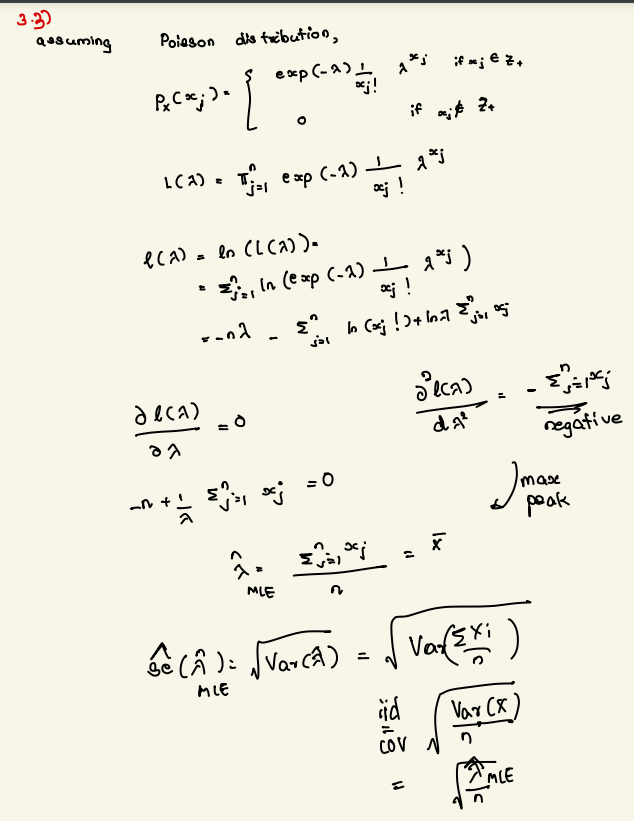

# 3.4 Performing K-S test and Permutation test

In [9]:
from scipy.stats import poisson, geom, binom
# We only use the libraries to calculate the distributions based on the parameters that we calculated


def ks_test_1_sample(data, cdf_func, *params):
    sorted_data = np.sort(data)
    sorted_data = np.sort(data)
    unique_sorted_data, counts = np.unique(sorted_data, return_counts=True)
    ecdf_plus = np.cumsum(counts) / len(sorted_data)
    ecdf_minus = np.concatenate(([0], ecdf_plus[:-1]))
    theoretical_cdfs = np.array([cdf_func(x, *params) for x in unique_sorted_data])
    return max(np.max(np.abs(ecdf_plus - theoretical_cdfs)), np.max(np.abs(ecdf_minus - theoretical_cdfs)))

def ks_test_2_sample(data1, data2):
    data1_sorted = np.sort(data1)
    data2_sorted = np.sort(data2)
    n1 = len(data1_sorted)
    n2 = len(data2_sorted)
    cdf1_plus = np.searchsorted(data1_sorted, data1_sorted, side='right') / n1
    cdf2_plus = np.searchsorted(data2_sorted, data1_sorted, side='right') / n2
    cdf1_minus = np.searchsorted(data1_sorted, data1_sorted-1, side='right') / n1
    cdf2_minus = np.searchsorted(data2_sorted, data1_sorted-1, side='right') / n2
    return max(np.max(np.abs(cdf1_plus - cdf2_plus)), np.max(np.abs(cdf1_minus - cdf2_minus)))

def permutation_test(data1, data2, n_permutations=1000):
    concat = np.concatenate([data1, data2])
    n = len(data1)
    diff_obs = np.abs(np.mean(data1) - np.mean(data2))
    count = 0
    for _ in range(n_permutations):
        np.random.shuffle(concat)
        new_data1 = concat[:n]
        new_data2 = concat[n:]
        diff_perm = np.abs(np.mean(new_data1) - np.mean(new_data2))
        if diff_perm >= diff_obs:
            count += 1
    return count / n_permutations

df = pd.read_csv('../dataset/updated_data_with_total_amount.csv')
lambda_poisson = np.mean(df['trip_duration'])
p_geometric = 1 / np.mean(df['trip_duration'])
mean_trip = np.mean(df['trip_duration'])
var_trip = np.var(df['trip_duration'], ddof=1)

sample_mean = np.mean(df['trip_duration'])
sample_var = np.var(df['trip_duration'])
n_binomial = sample_mean**2 / (sample_mean - sample_var)
p_binomial = 1 - (sample_var/sample_mean)

ks_poisson = ks_test_1_sample(df['fare_amount'], poisson.cdf, lambda_poisson)
ks_geometric = ks_test_1_sample(df['fare_amount'], geom.cdf, p_geometric)
ks_binomial = ks_test_1_sample(df['fare_amount'], binom.cdf, n_binomial, p_binomial)
ks_2_sample = ks_test_2_sample(df['trip_duration'], df['fare_amount'])
perm_p_value = permutation_test(df['trip_duration'], df['fare_amount'], 1000)

print(f"1-sample KS Test (Poisson): {ks_poisson}")
print(f"1-sample KS Test (Geometric): {ks_geometric}")
print(f"1-sample KS Test (Binomial): {ks_binomial}")
print(f"2-sample KS Test: {ks_2_sample}")
print(f"Permutation Test P-value: {perm_p_value}")

1-sample KS Test (Poisson): 0.9995542454019748
1-sample KS Test (Geometric): 0.917654783388853
1-sample KS Test (Binomial): nan
2-sample KS Test: 0.9720428260173521
Permutation Test P-value: 0.0


For c = 0.05,

Fare amount do not follow, Poisson or Geometric or Binomial (Reject H0) because d = $\max_{\alpha}|F_X(\alpha) - \hat{F_D}(\alpha)|$ > c, for binomial MME, both n and p are negative numbers indicating that it does not follow binomial distribution.

Trip Duration and fare amount also do not follow each other's distribution as d = $\max_{\alpha}|F_X(\alpha) - \hat{F_D}(\alpha)|$ > c (Reject H0) for KS test and for Permutation test p_value < c (Reject H0).


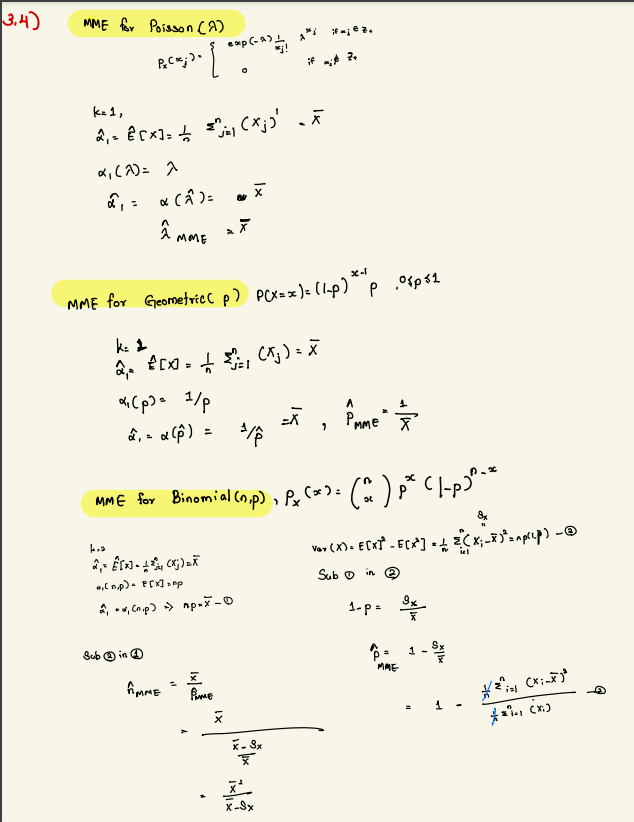

# 3.5 Linear regression

In [10]:
# Load the dataset
df = pd.read_csv('../dataset/updated_data_with_total_amount.csv')

def simple_linear_regression(data, x_cols, y_col):
    """
    Perform simple or multiple linear regression using the normal equation.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - x_cols: list of column names to use as predictors.
    - y_col: string, the name of the column to use as the response variable.

    Returns:
    - Tuple containing the coefficients of the regression and the SSE.
    """
    # Prepare the data matrix X (with an intercept) and vector Y
    X = np.column_stack((np.ones(len(data)), *[data[col] for col in x_cols]))
    Y = data[y_col].values

    # Calculate the coefficients using the normal equation
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    # print(beta.shape)
    # Calculate predictions and SSE for the model
    predictions = X @ beta
    sse = np.sum((Y - predictions) ** 2)
    msqe=sse/len(Y)
    mape = np.mean(np.abs((Y - predictions) / Y)) * 100
    # Return the coefficients and SSE
    return beta, sse,msqe,mape

x_columns = ['trip_duration']  # Predictor columns  'trip_distance'
y_column = 'total_amount'  # Response column

beta, sse1,msqe,mape1 = simple_linear_regression(df, x_columns, y_column)
print("Separate Models:")
print("Trip Duration - SSE:", sse1, "MAPE:", mape1)
print("Coefficients (β0, β1):", beta[0],beta[1])
print(msqe)
x_columns = ['trip_distance']  # Predictor columns  'trip_distance'
beta, sse2,msqe,mape2 = simple_linear_regression(df, x_columns, y_column)
print("Trip Distance - SSE:", sse2, "MAPE:", mape2)
print("Coefficients (β0, β1):", beta[0],beta[1])
print(msqe)


print("\nCombined Model:")
x_columns = ['trip_duration','trip_distance']  # Predictor columns  'trip_distance'
beta, sse2,msqe,mape2 = simple_linear_regression(df, x_columns, y_column)
print("Trip Distance and Duratio ncombined - SSE:", sse2, "MAPE:", mape2)
print("Coefficients (β0, β1, β2):", beta[0],beta[1],beta[2])
# print(msqe)

Separate Models:
Trip Duration - SSE: 704780746024.415 MAPE: 164.04955919081385
Coefficients (β0, β1): 14.537572146993712 0.023317568721636008
5503820.652576785
Trip Distance - SSE: 614886698906.6664 MAPE: 141.22076261557487
Coefficients (β0, β1): 22.1601547144386 1.517802382081327
4801814.084064148

Combined Model:
Trip Distance and Duratio ncombined - SSE: 498463253730.2 MAPE: 81.20313799035969
Coefficients (β0, β1, β2): 2.422177738684702 0.017087532292611476 1.2588155254309228


### Regression Results Overview
1. **Separate Models:**
   - **Trip Duration Model:**
     - **SSE:** 704,780,746,024.4152
     - **MAPE:** 164.049%
     - **Coefficients (β0, β1):** 14.5376 (intercept), 0.0233 (slope)
   - **Trip Distance Model:**
     - **SSE:** 614,886,698,906.6666
     - **MAPE:** 141.221%
     - **Coefficients (β0, β1):** 22.1602 (intercept), 1.5178 (slope)

2. **Combined Model:**
   - **SSE:** 498,463,253,730.19995
   - **MAPE:** 81.203%
   - **Coefficients (β0, β1, β2):** 2.4222 (intercept), 0.0171 (slope for trip duration), 1.2588 (slope for trip distance)

### Observations and Analysis
- **Effectiveness of Models:**
  - The **combined model** has a significantly lower SSE and MAPE compared to the separate models. This indicates that using both `trip_duration` and `trip_distance` together in a single model results in a better fit and more accurate predictions of `total_amount`.
  - The reduction in SSE (from over 700 billion in separate models to under 500 billion in the combined model) suggests that the combined model captures a substantial amount of the variability in `total_amount` that neither of the separate models could account for on their own.
  - Similarly, the MAPE is considerably lower in the combined model (81.203% vs. over 140% in separate models), highlighting improved prediction accuracy when both predictors are used together.

- **Coefficients Analysis:**
  - The coefficients (β1 and β2) in the combined model are different from the coefficients in the separate models, which is a result of the interaction between `trip_duration` and `trip_distance` when they are included together. The coefficients in the combined model are likely compensating for the shared variance between these two predictors.
  - In the separate models, the coefficient for `trip_distance` is significantly higher than for `trip_duration`, suggesting that `trip_distance` alone might be a stronger predictor of `total_amount` compared to `trip_duration`.

- **Practical Implications:**
  - The significantly lower coefficients in the combined model for both predictors indicate that each unit increase in `trip_duration` and `trip_distance` has a smaller impact on `total_amount` when considered together, compared to when they are modeled separately. This could suggest overlapping effects where the influence of one variable might diminish when the other is controlled for, pointing towards a potential multicollinearity issue or simply the shared contribution of these variables to the fare amount.
  - Practically, the combined model offers a more holistic approach to predicting fares in scenarios where both distance and duration are known. It provides a more nuanced understanding of how these factors together influence the fare, which can be critical for pricing strategies or operational adjustments in transportation services.

### Conclusion
The analysis clearly supports the superiority of the combined model over separate models when predicting fares based

# 3.6 Time Series Analysis

In [11]:
# Load dataset
df = pd.read_csv('../dataset/updated_data_with_total_amount.csv', parse_dates=['lpep_pickup_datetime'])
df['date'] = df['lpep_pickup_datetime'].dt.date
daily_median = df.groupby('date')['total_amount'].median()

# Training and test data
train = daily_median.iloc[:-1]
test = daily_median.iloc[-1]

# Helper function for MAPE
def calculate_mape(actual, predicted):
    return np.abs((actual - predicted) / actual) * 100

# Autoregressive function
def auto_regression(train, lags):
    X = np.column_stack([train.shift(i) for i in range(1, lags + 1)])
    X = X[lags:, :]  # Remove NaNs
    y = train.values[lags:]
    # Linear regression
    coef = np.linalg.inv(X.T @ X) @ X.T @ y
    # Prediction for the next point
    recent_data = train.values[-lags:][::-1]
    prediction = coef @ recent_data
    return prediction

# EWMA function
def ewma(train, alpha):
    weights = np.array([alpha * (1 - alpha)**i for i in range(len(train))][::-1])
    return np.sum(weights * train) / np.sum(weights)

# SMA function
def simple_moving_average(train, window):
    if len(train) < window:
        return np.nan
    return np.mean(train[-window:])

# AR(2) Prediction
pred_ar2 = auto_regression(train, 2)
mape_ar2 = calculate_mape(test, pred_ar2)

# AR(3) Prediction
pred_ar3 = auto_regression(train, 3)
mape_ar3 = calculate_mape(test, pred_ar3)

# EWMA Prediction
pred_ewma = ewma(train, 0.3)
mape_ewma = calculate_mape(test, pred_ewma)

# SMA Prediction
pred_sma = simple_moving_average(train, 7)
mape_sma = calculate_mape(test, pred_sma)

# Print results
print("AR(2) Prediction:", pred_ar2, "MAPE:", mape_ar2)
print("AR(3) Prediction:", pred_ar3, "MAPE:", mape_ar3)
print("EWMA Prediction:", pred_ewma, "MAPE:", mape_ewma)
print("SMA Prediction:", pred_sma, "MAPE:", mape_sma)

AR(2) Prediction: 17.168803760146943 MAPE: 2.4499786355287396
AR(3) Prediction: 17.113224811959217 MAPE: 2.765768113868093
EWMA Prediction: 17.111849556018402 MAPE: 2.7735820680772676
SMA Prediction: 17.001428571428573 MAPE: 3.4009740259740266


# 3.7 Chi-Square Test

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import chi2

# Load the dataset
df = pd.read_csv('../dataset/updated_data_with_total_amount.csv')

# Calculate medians
median_tip = df['tip_amount'].median()
median_passenger = df['passenger_count'].median()

# Categorize data into 'high' and 'low' based on the median
df['tip_category'] = np.where(df['tip_amount'] >= median_tip, 'High', 'Low')
df['passenger_category'] = np.where(df['passenger_count'] >= median_passenger, 'High', 'Low')

# Create a contingency table
contingency_table = pd.crosstab(df['tip_category'], df['passenger_category'])

# Calculate the total number of observations
N = contingency_table.values.sum()

# Compute expected frequencies
expected = np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / N

# Compute Chi-Square statistic
chi_squared_stat = ((contingency_table - expected) ** 2 / expected).sum().sum()

# Degrees of freedom
degrees_of_freedom = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)

# Compute p-value using the survival function (1 - CDF)
p_value = chi2.sf(chi_squared_stat, degrees_of_freedom)

# Output the results
print("Chi-Square Test results:")
print("Chi-Square Statistic:", chi_squared_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)
print("Expected Frequencies:\n", expected)

# Assess the result
if p_value < 0.05:
    print("Result: Dependent (reject H0)")
else:
    print("Result: Independent (fail to reject H0)")

Chi-Square Test results:
Chi-Square Statistic: 162.52952946382538
P-value: 3.169588164403562e-37
Degrees of Freedom: 1
Expected Frequencies:
 [[60075.98825486  5210.01174514]
 [57758.01174514  5008.98825486]]
Result: Dependent (reject H0)


### Chi-Square Test Overview

- **Chi-Square Statistic**: 162.53
  - This value is quite high, indicating a strong deviation from the expected frequencies under the null hypothesis (which assumes independence between the variables).
- **P-value**: 3.17e-37
  - This extremely low p-value (practically zero) strongly suggests rejecting the null hypothesis that `tip_amount` is dependent on the passenger category.

# 3.8 Bayesian Test (a)

In [13]:
# Load the dataset
df = pd.read_csv('../dataset/updated_data_with_total_amount.csv', parse_dates=['lpep_pickup_datetime'])
df['month'] = df['lpep_pickup_datetime'].dt.month

# Filter the data for the first month and trip_distance constraints
df_filtered = df[(df['month'] == 4) & (df['trip_distance'] > 0) & (df['trip_distance'] <= 10)]
# Sampling parameters
n = 1000
num_samples = 30
data_sd = 2
data_var = data_sd**2


# Prior distribution parameters
m = 2.25 # 'a' from the assingnment6 q1a
prior_sd = 1.95
prior_var = prior_sd**2  # Variance of the prior sigma_squared=b^squared(from assignemnt )

# Create samples and calculate Bayesian updates
posterior_means = []
posterior_sds = []

for i in range(1, 101, 100//num_samples):  # Generate random states from 1 to 100
    sample = df_filtered['trip_distance'].sample(n=n, random_state=i)
    sample_mean = sample.mean()
    # Bayesian update for normal prior and likelihood
    updated_sd = np.sqrt((prior_var * data_var/n) / (prior_var + (data_var/n))) # based on the formula from the assignment 6- question 1a
    updated_mean = ((prior_var * sample_mean) + (m * data_var/n)) / (prior_var + data_var/n)

    posterior_means.append(updated_mean)
    posterior_sds.append(updated_sd)
    if(len(posterior_sds)==num_samples):
      break


# Reporting results
updated_mean = np.mean(posterior_means)
updated_sd = np.mean(posterior_sds)

print("Updated mean (μ1):", updated_mean)
print("Updated standard deviation (σ1):", updated_sd)


Updated mean (μ1): 2.566495732300013
Updated standard deviation (σ1): 0.06321231417692073


## Interpretation:
i) Comment: As n (the number of observations in each sample) tends towards infinity, the influence of the prior diminishes and the posterior mean approaches the sample mean, while the posterior standard deviation decreases, reflecting increased certainty about the estimate.

ii) Substitution: Substituting values involves simply using the numerical results from the code. These values represent our best estimates for the parameters based on the prior belief and the data observed.

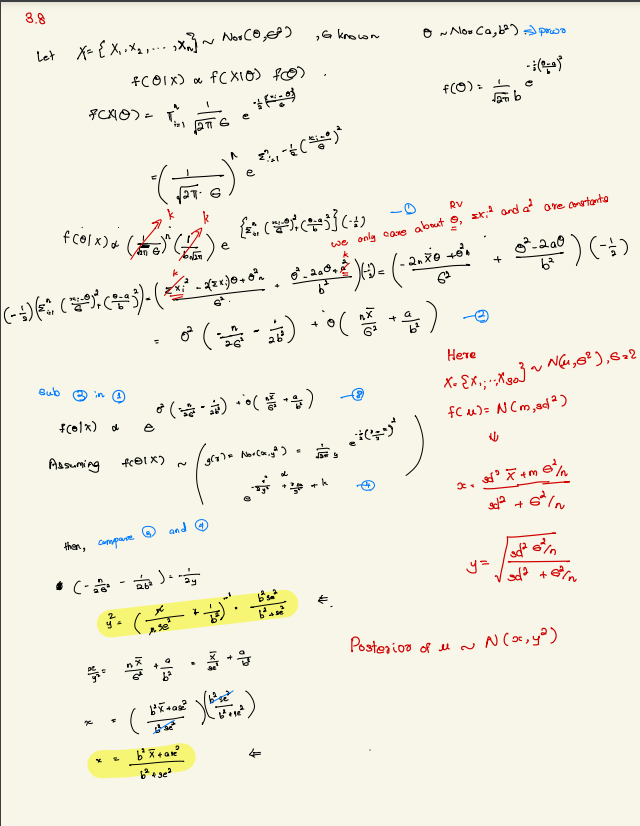

# 3.8 Bayesian Test(b)

In [14]:
# Load the dataset
df = pd.read_csv('../dataset/updated_data_with_total_amount.csv', parse_dates=['lpep_pickup_datetime'])
df['month'] = df['lpep_pickup_datetime'].dt.month

# Filter data for the second month within trip distance constraints
df_filtered_2 = df[(df['month'] == 5) & (df['trip_distance'] > 0) & (df['trip_distance'] <= 10)]

# Sampling parameters for the second month
n = 1000
num_samples = 30

# New prior parameters (results from the first month)
m_new = updated_mean  # Use the updated mean from the first month analysis
sd_new = updated_sd  # Use the updated standard deviation from the first month analysis

prior_var = sd_new**2 #Prior variance
data_std = 2
data_var = data_std**2

# Create samples and calculate Bayesian updates for the second month
posterior_means_2 = []
posterior_sds_2 = []

for i in range(101, 201, 100//num_samples):  # Generate random states from 101 to 200
    sample = df_filtered_2['trip_distance'].sample(n=n, random_state=i)
    sample_mean = sample.mean()

    updated_sd_2 = np.sqrt((prior_var * data_var/n) / (prior_var + (data_var/n))) # based on the formula from the assignment 6- question 1a
    updated_mean_2 = ((prior_var * sample_mean) + (m_new * data_var/n)) / (prior_var + data_var/n)

    posterior_means_2.append(updated_mean_2)
    posterior_sds_2.append(updated_sd_2)

    if(len(posterior_sds)==num_samples):
      break

# Reporting results for the second month
updated_mean_2 = np.mean(posterior_means_2)
updated_sd_2 = np.mean(posterior_sds_2)

print("Updated mean (μ2) for the second month:", updated_mean_2)
print("Updated standard deviation (σ2) for the second month:", updated_sd_2)
print("Maximum A Posteriori (MAP) for the obtained posterior distribution:", updated_mean_2)


Updated mean (μ2) for the second month: 2.5984460612432647
Updated standard deviation (σ2) for the second month: 0.044709603146125466
Maximum A Posteriori (MAP) for the obtained posterior distribution: 2.5984460612432647
